In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../dataset/')
from dataset import AsbestosDataSet
import os 
from pathlib import Path
import json
from pycocotools.coco import COCO
from PIL import Image
import cv2
from dataset import load_img
from utils import get_paths_from_dirs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##Конверт

In [6]:
def create_annotation_mask(coco_set, img_indx, image_root, category_name = 'asbest'):
    cat_ids  = coco_set.getCatIds(catNms=[category_name])
    img_ids  = coco_set.getImgIds(catIds=cat_ids );
    image_dict = coco_set.loadImgs(img_indx)[0]
    ann_ids = coco_set.getAnnIds(imgIds=image_dict['id'], catIds=cat_ids, iscrowd=None)
    anns = coco_set.loadAnns(ann_ids)
    if len(anns) > 0:
        for i in range(len(anns)):
            if i == 0:
                mask = np.array(coco_set.annToMask(anns[0]), dtype = np.int64)
            else:
                mask += coco_set.annToMask(anns[i])

        mask[mask>1] = 1#for stones!
    else: 
        w = coco_set.loadImgs(1)[0]['width']
        h = coco_set.loadImgs(1)[0]['height']
        mask = np.zeros((h,w))
    return mask

In [7]:
#Create asbest segmentation from annotation file
def create_segmentation_from_annotation(coco_dataset, image_root, out_segmentation_root, category_name):
    for idx, image_name in coco_dataset.imgs.items():
        name = image_name['file_name'].split('/')[-1].split('.')[0]
        try:
            mask = create_annotation_mask(coco_dataset, idx, image_root, category_name)
            plt.imsave(os.path.join(out_segmentation_root, name + '.png'), mask, cmap='Greys')
        except Exception as err:
            print(idx, err)       
        if idx%10 == 0:
            print(idx)

In [4]:
coco_set = COCO('/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/annotations/instances_default.json')
# coco_set = COCO('/home/kirill/Учеба/asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0/annotations/instances_default.json')
coco_set.dataset['categories']

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


[{'id': 1, 'name': 'stone', 'supercategory': ''},
 {'id': 2, 'name': 'asbest', 'supercategory': ''}]

### asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0 

In [4]:
# coco_set = COCO('/home/kirill/Учеба/asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0/annotations/instances_default.json')
print(coco_set.dataset['categories'])
image_path = '/home/kirill/Учеба/asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0/images/'

mask = create_annotation_mask(coco_set, 52, image_path, category_name='asbest')
fig = plt.figure(dpi = 100)
plt.imshow(mask)

NameError: name 'coco_set' is not defined

In [12]:
segmentation_root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationAsbest'
segmentation_rock_root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationRock'
image_path = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/JPEGImages/'

In [13]:
create_segmentation_from_annotation(coco_set, image_path, segmentation_rock_root, 'asbest')

10
20
30
40
50


## lab_common_set

In [8]:
dir_image = '/home/kirill/Учеба/asbestos/task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/images/asbestos/stones/lab_common_camera'
files = os.listdir(dir_image)

In [9]:
image = np.array(Image.open(Path(dir_image, files[5])))
image.shape

(5184, 3456, 4)

In [10]:
coco_set = COCO('/home/kirill/Учеба/asbestos/task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/annotations/instances_default.json')
coco_set.dataset['categories']

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


[{'id': 1, 'name': 'stone', 'supercategory': ''},
 {'id': 2, 'name': 'asbest', 'supercategory': ''}]

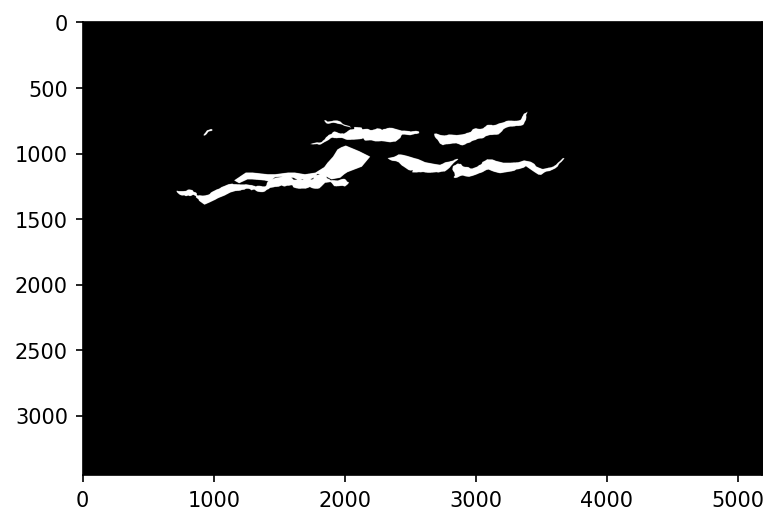

In [11]:
mask = create_annotation_mask(coco_set, 32, dir_image,'asbest')
fig = plt.figure(dpi = 150)
plt.imshow(mask,cmap = 'Greys_r')

In [12]:
segment_dir = '/home/kirill/Учеба/asbestos/task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/SegmentationAsbest'
create_segmentation_from_annotation(coco_set,dir_image, segment_dir, 'asbest')

10
20
30
40


In [15]:
image_dir = '../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/images/asbestos/stones/lab_common_camera/'
mask_dir  = '../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/SegmentationAsbest'
dataset = AsbestosDataSet(image_dir, mask_dir)

In [16]:
def rotate_image_mask(image_dict):
    image = image_dict['image']
    mask  = image_dict['mask']
    name  = image_dict['path']
    image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    mask = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
    mask = np.logical_not(mask).astype(np.long)
    return image, mask

In [17]:
for ex in dataset:
    shape = ex['image'].shape
    if shape[0] > shape[1]:
        image, mask = rotate_image_mask(ex)
        name = ex['path']
        
        plt.imsave(os.path.join(image_dir, name), image)
        plt.imsave(os.path.join(mask_dir, name), mask, cmap = 'Greys_r')
        print(ex['path'],' перевернут')
    else:
        print(ex['path'],' обработан')

IMG_2688.png  обработан
IMG_2689.png  обработан
IMG_2690.png  обработан
IMG_2691.png  обработан


<ipython-input-16-25a47df0bc11>:7: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.logical_not(mask).astype(np.long)


IMG_2692.png  перевернут
IMG_2693.png  обработан
IMG_2694.png  обработан
IMG_2695.png  обработан
IMG_2696.png  обработан
IMG_2697.png  обработан
IMG_2698.png  перевернут
IMG_2699.png  перевернут
IMG_2700.png  обработан
IMG_2701.png  обработан
IMG_2702.png  обработан
IMG_2703.png  перевернут
IMG_2704.png  перевернут
IMG_2705.png  обработан
IMG_2708.png  обработан
IMG_2709.png  обработан
IMG_2710.png  обработан
IMG_2711.png  обработан
IMG_2712.png  обработан
IMG_2713.png  обработан
IMG_2714.png  обработан
IMG_2715.png  обработан
IMG_2716.png  обработан
IMG_2717.png  обработан
IMG_2718.png  обработан
IMG_2719.png  обработан
IMG_2720.png  обработан
IMG_2721.png  обработан
IMG_2722.png  перевернут
IMG_2723.png  перевернут
IMG_2724.png  обработан
IMG_2725.png  обработан
IMG_2726.png  перевернут
IMG_2727.png  перевернут
IMG_2728.png  перевернут
IMG_2729.png  обработан
IMG_2730.png  перевернут
IMG_2731.png  перевернут
IMG_2732.png  обработан
IMG_2733.png  обработан
IMG_2734.png  обработан
IMG_

In [1]:
### Резайз

In [35]:
out_dir = '/home/office/kirilman/Projects/asbestos/temp_set1/'
paths = get_paths_from_dirs(['/home/office/kirilman/Projects/asbestos/temp_set/'],['bmp'])
for p in paths:
    img = load_img(p, float)
    img = cv2.resize(img, (1296,1024))
    cv2.imwrite(out_dir+p.name, img)

In [33]:
paths


[]

In [31]:
p.name

'27-04-2021-15-35-13_35_3_90_detailed.bmp'

In [18]:
img.shape2

TypeError: unsupported operand type(s) for //: 'tuple' and 'int'

In [16]:
2592/2

1296.0